# Step I of Proposed Method :
* fully supervised pre-training of MLP on the 10,124 fully annotated tiles
* MLP on top of ResNet50 features
* trained using SGD with lr=0.01 and momentum=0.8
* minimized weightd BCE loss with regard to class imbalance ratio
* used heavy 50% dropout 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Step-I-of-Proposed-Method-:" data-toc-modified-id="Step-I-of-Proposed-Method-:-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Step I of Proposed Method :</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span><ul class="toc-item"><li><span><a href="#Paths" data-toc-modified-id="Paths-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Paths</a></span></li><li><span><a href="#Build-DF-with-pertinent-information" data-toc-modified-id="Build-DF-with-pertinent-information-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Build DF with pertinent information</a></span></li><li><span><a href="#Extract-features-of-annotated-tiles-from-image-features-&amp;-build-training-set" data-toc-modified-id="Extract-features-of-annotated-tiles-from-image-features-&amp;-build-training-set-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Extract features of annotated tiles from image features &amp; build training set</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Train-K-fold-CV" data-toc-modified-id="Train-K-fold-CV-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train K-fold CV</a></span></li><li><span><a href="#Plot-Train-/-Val-CV-loss" data-toc-modified-id="Plot-Train-/-Val-CV-loss-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Plot Train / Val CV loss</a></span></li><li><span><a href="#Plot-GT-and-Prediction-distribution" data-toc-modified-id="Plot-GT-and-Prediction-distribution-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Plot GT and Prediction distribution</a></span></li><li><span><a href="#Retrain-on-All-Tiles-&amp;-Save-Model" data-toc-modified-id="Retrain-on-All-Tiles-&amp;-Save-Model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Retrain on All Tiles &amp; Save Model</a></span></li></ul></div>

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

print("keras version: ", keras.__version__)
print("tf version: ", tf.__version__)

from keras.layers import *
from keras.models import *
from keras import optimizers 

from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

%matplotlib notebook

Using TensorFlow backend.


keras version:  2.3.1
tf version:  2.1.0


# Parameters

In [2]:
n_splits = 5
batch_size = 50
lr = 0.01         
epochs = 50
fc_layer_size = [100, 20]
dropout_rate = 0.5

# Data

## Paths

In [3]:
data_dir = Path('../chowder_data')

train_dir = data_dir / "train_input" / "resnet_features"

train_tile_annotations = data_dir /  "train_input" / "train_tile_annotations.csv"
train_image_annotations = data_dir /  "train_output.csv"

## Build DF with pertinent information

In [4]:
# get DF with tile-wise labels
df_tiles = pd.read_csv(train_tile_annotations, header=0, names = ['Filename', 'Target'])

# extract image ID from tile filename
ids = [re.search("ID_(\d+)_", str(filename)).group(1) for filename in df_tiles['Filename']]
df_tiles['ID_Image'] = pd.to_numeric(ids)

# extract tile ID from tile filename
ids = [re.search("_tile_(\d+)_", str(filename)).group(1) for filename in df_tiles['Filename']]
df_tiles['ID_Tile'] = pd.to_numeric(ids)

In [5]:
# get DF with image-wise labels
df = pd.read_csv(train_image_annotations)

# get paths of image-wise Resnet features & add them to DF
filenames_train = sorted(train_dir.glob("*.npy"))
df['Path'] = filenames_train

# drop image filenames of tiles (we are using the features only)
df_tiles = df_tiles.drop(columns=['Filename'])

# merge tile & image DFs
df = pd.merge(df, df_tiles, left_on="ID", right_on="ID_Image", suffixes=('_Image', '_Tile'))
df.head(7)

,ID,Target_Image,Path,Target_Tile,ID_Image,ID_Tile
0,35,1,../chowder_data/train_input/resnet_features/ID...,1.0,35,0
1,35,1,../chowder_data/train_input/resnet_features/ID...,0.0,35,1
2,35,1,../chowder_data/train_input/resnet_features/ID...,0.0,35,2
3,35,1,../chowder_data/train_input/resnet_features/ID...,0.0,35,3
4,35,1,../chowder_data/train_input/resnet_features/ID...,0.0,35,4
5,35,1,../chowder_data/train_input/resnet_features/ID...,0.0,35,5
6,35,1,../chowder_data/train_input/resnet_features/ID...,0.0,35,6


## Extract features of annotated tiles from image features & build training set

In [6]:
X = []
Y = []
df_grouped = df.groupby('Path')

# iterate over each image and extract tile features invididually
for image_path, df_group in df_grouped:
    # get image features
    image_features = np.load(image_path)
    # extract anootated tile features f
    tile_ids = df_group['ID_Tile']
    tiles_features = image_features[tile_ids,3:]
    # extract anootated tile features
    tile_labels = df_group['Target_Tile']
    X.append(tiles_features)
    Y.extend(tile_labels)

X = np.concatenate(X, axis=0)
Y = np.array(Y)

print(X.shape, Y.shape)

(10124, 2048) (10124,)


# Model

In [7]:
def get_model():
    tile = Input((2048,))
    x = tile
    for fc in fc_layer_size:
        x = Dense(fc, activation='sigmoid')(x)
        if dropout_rate > 0:
            x = Dropout(dropout_rate)(x)
    tile_prediction = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=tile, outputs=tile_prediction)
    
    model.compile(optimizers.SGD(lr, momentum=0.8),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.AUC()])
    return model

In [8]:
get_model().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               204900    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 206,941
Trainable params: 206,941
Non-trainable params: 0
_____________________________________________________

# Train K-fold CV

In [9]:
%%time

# compute class weights 
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y), y=Y)
print("class weights", class_weights)

kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

history_folds = []
aucs = []

for fold, (i_train, i_val) in enumerate(kf.split(X, Y)):
    
    print("Fold {} / {}".format(fold+1, n_splits))
    
    # get data
    X_train, Y_train = X[i_train], Y[i_train]
    X_val, Y_val = X[i_val], Y[i_val]
    
    # build model
    model = get_model()
    
    # train model
    history = model.fit(
        X_train,Y_train,
        validation_data=(X_val, Y_val),
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
        class_weight=dict(enumerate(class_weights)))
    
    # compute and save Val AUC
    auc = model.evaluate(X_val, Y_val)[-1]
    print("Val AUC = {:.3f}".format(auc))
    aucs.append(auc)
    history_folds.append(history.history)
    
aucs = np.array(aucs)
print("Val AUC: mean {:.3f}, std {:.3f}".format(aucs.mean(), aucs.std()))

class weights [0.53753849 7.15983027]
Fold 0 / 5
2025/2025 [==============================] - 0s 50us/step
Val AUC = 0.955
Fold 1 / 5
2025/2025 [==============================] - 0s 49us/step
Val AUC = 0.951
Fold 2 / 5
2025/2025 [==============================] - 0s 50us/step
Val AUC = 0.955
Fold 3 / 5
2025/2025 [==============================] - 0s 49us/step
Val AUC = 0.957
Fold 4 / 5
2024/2024 [==============================] - 0s 49us/step
Val AUC = 0.952
Val AUC: mean 0.954, std 0.002
CPU times: user 1min 56s, sys: 4.16 s, total: 2min 1s
Wall time: 2min 1s


# Plot Train / Val CV loss

<IPython.core.display.Javascript object>


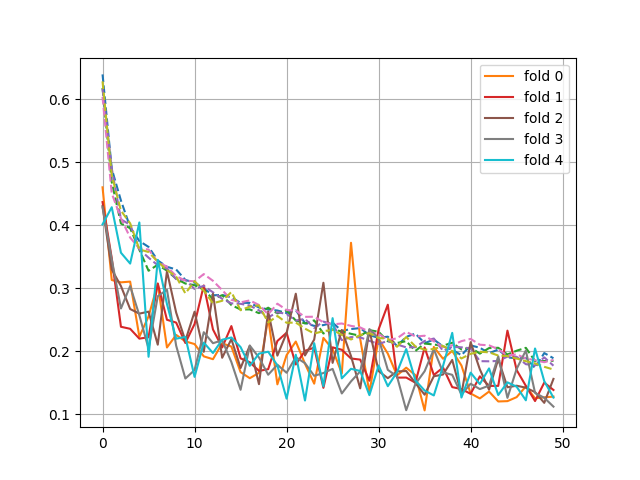

In [10]:
plt.figure()
for fold in range(len(history_folds)):
    plt.plot(history_folds[fold]['loss'], '--')
    plt.plot(history_folds[fold]['val_loss'], label='fold {}'.format(fold))
#plt.yscale('log')
plt.legend()
plt.grid('on')

# Plot GT and Prediction distribution
**sanity check** expecting bimodal distribution for both \
NB: looking at one fold only

<IPython.core.display.Javascript object>


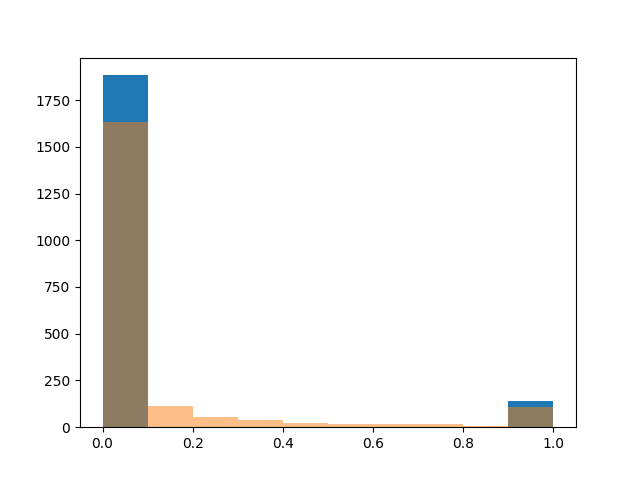

In [11]:
Y_pred=model.predict(X_val)
plt.figure()
_=plt.hist(Y_val)
_=plt.hist(Y_pred, alpha=0.5)

# Retrain on All Tiles & Save Model

In [12]:
%%time
model = get_model()

model.fit(
        X,Y,
        batch_size=batch_size,
        epochs=epochs,
        verbose=0,
        class_weight=dict(enumerate(class_weights)))

model.save("base_model.h5", include_optimizer=False)

CPU times: user 24.4 s, sys: 751 ms, total: 25.1 s
Wall time: 25.2 s
